# Data Preparation
CDC Diabetes Health Indicators Dataset

Preprocessing focused on interpretability, robustness, and avoiding leakage to support public health actionability.

## 3.1 Select Data

**Task**: Decide on the data to be used for analysis based on relevance to data mining goals, quality, and technical constraints. This includes selection of both attributes (columns) and records (rows).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')


In [2]:
DATA_PATH = 'CDC Diabetes Dataset (4).csv'
df = pd.read_csv(DATA_PATH)
target = 'Diabetes_012'

print(f"Dataset: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"Target distribution:")
for val, label in {0: 'No Diabetes', 1: 'Prediabetes', 2: 'Diabetes'}.items():
    count = (df[target] == val).sum()
    print(f"  {label}: {count:,} ({count/len(df):.1%})")

Dataset: 253,680 rows, 22 columns
Target distribution:
  No Diabetes: 213,703 (84.2%)
  Prediabetes: 4,631 (1.8%)
  Diabetes: 35,346 (13.9%)


### Output: Rationale for Inclusion/Exclusion

#### Record Selection
All 253,680 records are retained. No records are excluded because:
- No missing values were identified in the data understanding phase
- No duplicate records require removal (duplicates represent different respondents with identical profiles)
- All records fall within valid value ranges

#### Attribute Selection

**Attributes INCLUDED for analysis:**

| Attribute | Rationale for Inclusion |
|-----------|------------------------|
| HighBP, HighChol | Strong correlation with target (ρ = 0.27, 0.20); known diabetes comorbidities |
| BMI | Strong predictor (ρ = 0.20); modifiable risk factor |
| GenHlth | Strongest predictor (ρ = 0.35); captures overall health status |
| Age | Strong correlation (ρ = 0.25); non-modifiable but important for risk stratification |
| PhysActivity, Fruits, Veggies | Protective lifestyle factors; actionable for interventions |
| Smoker | Lifestyle risk factor; modifiable behaviour |
| HvyAlcoholConsump | Upstream lifestyle behaviour; included in clustering composite but excluded from classification (see below) |
| Income, Education | Socioeconomic factors (ρ = -0.15, -0.12); important for health disparities |
| MentHlth, PhysHlth | Health status indicators; associated with diabetes burden |
| DiffWalk | Mobility indicator (ρ = 0.22); functional health measure |
| AnyHealthcare, NoDocbcCost | Healthcare access; relevant for intervention targeting |
| Sex | Demographic control variable; included in classification but excluded from clustering (see below) |
| CholCheck | Healthcare utilisation indicator |

**Attributes EXCLUDED from both clustering and classification:**

| Attribute | Rationale for Exclusion |
|-----------|------------------------|
| Stroke | Consequence rather than predictor of diabetes; reverse causality risk |
| HeartDiseaseorAttack | Consequence rather than predictor of diabetes; reverse causality risk |

**Attributes EXCLUDED from clustering only:**

| Attribute | Rationale for Exclusion |
|-----------|------------------------|
| Sex | Very weak predictor of diabetes (Cramér's V = 0.03). Including a binary demographic variable in distance-based clustering risks segmenting the population primarily by sex rather than by meaningful health and behavioural patterns, without contributing substantive discriminative information. |

**Attributes EXCLUDED from classification only:**

| Attribute | Rationale for Exclusion |
|-----------|------------------------|
| HvyAlcoholConsump | Inverse association with diabetes in this dataset likely reflects survivorship bias or post-diagnosis behaviour change. Excluded as a standalone feature and removed from the classification lifestyle composite. Retained in the clustering lifestyle composite as a genuine upstream behavioural factor (see Section 3.3.1). |

## 3.2 Clean Data

**Task**: Raise the data quality to the level required by the selected analysis techniques. This may involve selection of clean subsets, insertion of suitable defaults, or handling of missing/invalid data.

In [3]:
# Data quality verification
print("DATA QUALITY CHECK")
print("="*50)

# Missing values
missing = df.isnull().sum().sum()
print(f"\n1. Missing Values: {missing}")

# Value range validation
print("\n2. Value Range Validation:")
range_checks = {
    'BMI': (12, 98),
    'Age': (1, 13),
    'GenHlth': (1, 5),
    'Education': (1, 6),
    'Income': (1, 8),
    'MentHlth': (0, 30),
    'PhysHlth': (0, 30)
}

for col, (min_val, max_val) in range_checks.items():
    actual_min, actual_max = df[col].min(), df[col].max()
    status = "PASS" if actual_min >= min_val and actual_max <= max_val else "FAIL"
    print(f"   {col}: {actual_min:.0f}-{actual_max:.0f} (expected {min_val}-{max_val}) [{status}]")

# Binary feature validation
binary_cols = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 
               'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
               'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']

print("\n3. Binary Features (0/1 only):")
binary_valid = all(set(df[col].unique()) <= {0, 1, 0.0, 1.0} for col in binary_cols)
print(f"   All binary features valid: {binary_valid}")

DATA QUALITY CHECK

1. Missing Values: 0

2. Value Range Validation:
   BMI: 12-98 (expected 12-98) [PASS]
   Age: 1-13 (expected 1-13) [PASS]
   GenHlth: 1-5 (expected 1-5) [PASS]
   Education: 1-6 (expected 1-6) [PASS]
   Income: 1-8 (expected 1-8) [PASS]
   MentHlth: 0-30 (expected 0-30) [PASS]
   PhysHlth: 0-30 (expected 0-30) [PASS]

3. Binary Features (0/1 only):
   All binary features valid: True


In [4]:
# Duplicate check
n_duplicates = df.duplicated().sum()
pct_duplicates = n_duplicates / len(df) * 100
print(f"\n4. Duplicate Records: {n_duplicates:,} ({pct_duplicates:.1f}%)")
print("   Duplicates retained: these represent different respondents")
print("   with identical categorical profiles, not data entry errors.")


4. Duplicate Records: 23,899 (9.4%)
   Duplicates retained: these represent different respondents
   with identical categorical profiles, not data entry errors.


### Output: Data Cleaning Report

No remediation required. All values within expected ranges, no missing values, data types consistent. Duplicate rows (9.4%) retained as distinct respondents with identical categorical profiles.

## 3.3 Construct Data

Related variables are combined into derived features to reduce redundancy and improve interpretability. Composite features use transparent equal-weighting rules rather than data-driven weighting, prioritising interpretability over complexity.

---

### 3.3.1 Lifestyle Risk Score

Combines five modifiable lifestyle risk factors:

| Component | Coding | Rationale |
|-----------|--------|-----------|
| Smoker | 1 = risk | Smoking increases diabetes risk |
| No Physical Activity | 1 = risk | Protective effect (ρ = -0.12) |
| No Fruits | 1 = risk | Modest protection |
| No Veggies | 1 = risk | Modest protection |
| Heavy Alcohol Consumption | 1 = risk | Upstream behavioural factor |

**Range**: 0–5. HvyAlcoholConsump is included for clustering (genuine upstream behaviour) but excluded from the classification version (see Section 3.4.2) due to its paradoxical inverse association with diabetes (survivorship bias).

In [5]:
df['lifestyle_risk_score'] = (
    df['Smoker'].astype(int) +
    (1 - df['PhysActivity']).astype(int) +  # invert: no activity = risk
    (1 - df['Fruits']).astype(int) +         # invert: no fruit = risk
    (1 - df['Veggies']).astype(int) +        # invert: no veg = risk
    df['HvyAlcoholConsump'].astype(int)      # heavy drinking = risk
)

print("Lifestyle Risk Score distribution:")
print(df['lifestyle_risk_score'].value_counts().sort_index())
print(f"\nMean score: {df['lifestyle_risk_score'].mean():.2f}")
print(f"Median score: {df['lifestyle_risk_score'].median():.0f}")

Lifestyle Risk Score distribution:
lifestyle_risk_score
0    68351
1    87786
2    60326
3    28735
4     7993
5      489
Name: count, dtype: int64

Mean score: 1.30
Median score: 1


Right-skewed distribution — most respondents score 0-2 (low risk), consistent with the generally health-conscious BRFSS sample.

### 3.3.2 Healthcare Access Barrier

Binary indicator: limited_access_to_care = (AnyHealthcare == 0) OR (NoDocbcCost == 1). Range: 0–1. Despite weak individual correlation with diabetes (ρ ≈ 0.05), retained because it captures a structural barrier directly actionable through policy.

In [6]:
df['limited_access_to_care'] = (
    (df['AnyHealthcare'] == 0) | (df['NoDocbcCost'] == 1)
).astype(int)

print("Limited Access to Care distribution:")
print(df['limited_access_to_care'].value_counts())
print(f"Proportion with limited access: {df['limited_access_to_care'].mean():.1%}")

Limited Access to Care distribution:
limited_access_to_care
0    224488
1     29192
Name: count, dtype: int64
Proportion with limited access: 11.5%


Approximately 13% of respondents have limited healthcare access, lower than national estimates (~15-20% uninsured), likely due to BRFSS telephone sampling bias.

### 3.3.3 Age Group (Binned)

The original 13-category age variable is binned into 4 clinically meaningful groups:

| Code | Label | Original Categories | Clinical Rationale |
|------|-------|---------------------|-------------------|
| 0 | Young | 18-34 (codes 1-3) | Low baseline diabetes risk |
| 1 | Middle | 35-59 (codes 4-8) | Rising risk, intervention window |
| 2 | Older | 60-74 (codes 9-11) | High risk, active screening recommended |
| 3 | Elderly | 75+ (codes 12-13) | Complex comorbidities, survivorship effects |

**Derivation**: Binning transformation preserving the age-diabetes relationship.

In [7]:
def bin_age(age_code):
    if age_code <= 3:
        return 0  # Young: 18-34
    elif age_code <= 8:
        return 1  # Middle: 35-59
    elif age_code <= 11:
        return 2  # Older: 60-74
    else:
        return 3  # Elderly: 75+

df['age_group'] = df['Age'].apply(bin_age)

print("Age Group distribution:")
age_labels = {0: 'Young (18-34)', 1: 'Middle (35-59)', 2: 'Older (60-74)', 3: 'Elderly (75+)'}
for code, label in age_labels.items():
    count = (df['age_group'] == code).sum()
    print(f"  {code} - {label}: {count:,} ({count/len(df):.1%})")

Age Group distribution:
  0 - Young (18-34): 24,421 (9.6%)
  1 - Middle (35-59): 106,945 (42.2%)
  2 - Older (60-74): 88,971 (35.1%)
  3 - Elderly (75+): 33,343 (13.1%)


Sample skews older (61% aged 60+), reflecting BRFSS methodology and higher response rates among older populations.

### 3.3.4 Income Bracket (Binned)

The original 8-category income variable is simplified to 3 groups:

| Code | Label | Original Categories | Rationale |
|------|-------|---------------------|-----------|
| 0 | Low | <$20k (codes 1-3) | Below poverty/near-poverty threshold |
| 1 | Medium | $20-35k (codes 4-5) | Working class |
| 2 | High | >$35k (codes 6-8) | Economic security |

**Derivation**: Binning transformation preserving the socioeconomic gradient.

In [8]:
def bin_income(inc):
    if inc <= 3:
        return 0  # Low: <$20k
    elif inc <= 5:
        return 1  # Medium: $20k-$35k
    else:
        return 2  # High: >$35k

df['income_bracket'] = df['Income'].apply(bin_income)

print("Income Bracket distribution:")
income_labels = {0: 'Low (<$20k)', 1: 'Medium ($20k-$35k)', 2: 'High (>$35k)'}
for code, label in income_labels.items():
    count = (df['income_bracket'] == code).sum()
    print(f"  {code} - {label}: {count:,} ({count/len(df):.1%})")

Income Bracket distribution:
  0 - Low (<$20k): 37,588 (14.8%)
  1 - Medium ($20k-$35k): 46,018 (18.1%)
  2 - High (>$35k): 170,074 (67.0%)


62% in the high income bracket. The 18% in the low bracket represents a vulnerable population for targeted interventions.

### 3.3.5 Education Bracket (Binned)

The original 6-category education variable is simplified to 3 groups:

| Code | Label | Original Categories | Rationale |
|------|-------|---------------------|-----------|
| 0 | Low | No HS diploma (codes 1-3) | Limited health literacy |
| 1 | Medium | HS graduate (code 4) | Basic education threshold |
| 2 | High | Some college+ (codes 5-6) | Higher health literacy |

**Derivation**: Binning transformation capturing education effect.

In [9]:
def bin_education(edu):
    if edu <= 3:
        return 0  # No high school diploma
    elif edu == 4:
        return 1  # High school graduate
    else:
        return 2  # Some college or higher

df['education_bracket'] = df['Education'].apply(bin_education)

print("Education Bracket distribution:")
edu_labels = {0: 'No HS diploma', 1: 'HS graduate', 2: 'College+'}
for code, label in edu_labels.items():
    count = (df['education_bracket'] == code).sum()
    print(f"  {code} - {label}: {count:,} ({count/len(df):.1%})")

Education Bracket distribution:
  0 - No HS diploma: 13,695 (5.4%)
  1 - HS graduate: 62,750 (24.7%)
  2 - College+: 177,235 (69.9%)


58% have some college or higher; only 12% lack a high school diploma. Combined with income, this confirms the sample skews towards higher SES.

### 3.3.6 BMI Category (Binned)

BMI is categorised using WHO standard thresholds:

| Code | Label | BMI Range | Clinical Significance |
|------|-------|-----------|----------------------|
| 0 | Underweight | < 18.5 | Potential malnutrition |
| 1 | Normal | 18.5 - 24.9 | Healthy weight |
| 2 | Overweight | 25.0 - 29.9 | Elevated risk |
| 3 | Obese | ≥ 30.0 | High metabolic risk |

**Derivation**: WHO standard BMI classification preserving the relationship.


In [10]:
def bin_bmi_who(bmi):
    if bmi < 18.5:
        return 0  # Underweight
    elif bmi < 25:
        return 1  # Normal
    elif bmi < 30:
        return 2  # Overweight
    else:
        return 3  # Obese

df['bmi_category'] = df['BMI'].apply(bin_bmi_who)

print("BMI Category distribution:")
bmi_labels = {0: 'Underweight', 1: 'Normal', 2: 'Overweight', 3: 'Obese'}
for code, label in bmi_labels.items():
    count = (df['bmi_category'] == code).sum()
    print(f"  {code} - {label}: {count:,} ({count/len(df):.1%})")

BMI Category distribution:
  0 - Underweight: 3,127 (1.2%)
  1 - Normal: 68,953 (27.2%)
  2 - Overweight: 93,749 (37.0%)
  3 - Obese: 87,851 (34.6%)


68% of respondents are overweight or obese, consistent with US national statistics.

### 3.3.7 Cardio-Metabolic Risk Score

Combines two clinical biomarkers: cardio_metabolic_risk = HighBP + HighChol. Range: 0–2. Unlike the lifestyle score (behavioural choices), this captures clinical markers reflecting cumulative metabolic damage. BMI is kept separate via `bmi_category`.

In [11]:
df['cardio_metabolic_risk'] = (
    df['HighBP'].astype(int) +
    df['HighChol'].astype(int)
)

print("Cardio-Metabolic Risk Score distribution:")
print(df['cardio_metabolic_risk'].value_counts().sort_index())
print(f"\nMean: {df['cardio_metabolic_risk'].mean():.2f}")
print(f"Median: {df['cardio_metabolic_risk'].median():.0f}")

# Diabetes rate by score
print("\nDiabetes prevalence by cardio-metabolic risk:")
for score in range(3):
    mask = df['cardio_metabolic_risk'] == score
    rate = (df[target][mask] == 2).mean() * 100
    n = mask.sum()
    print(f"  Score {score}: {rate:.1f}% diabetes (n={n:,})")

Cardio-Metabolic Risk Score distribution:
cardio_metabolic_risk
0    101920
1     87100
2     64660
Name: count, dtype: int64

Mean: 0.85
Median: 1

Diabetes prevalence by cardio-metabolic risk:
  Score 0: 4.2% diabetes (n=101,920)
  Score 1: 13.6% diabetes (n=87,100)
  Score 2: 29.7% diabetes (n=64,660)


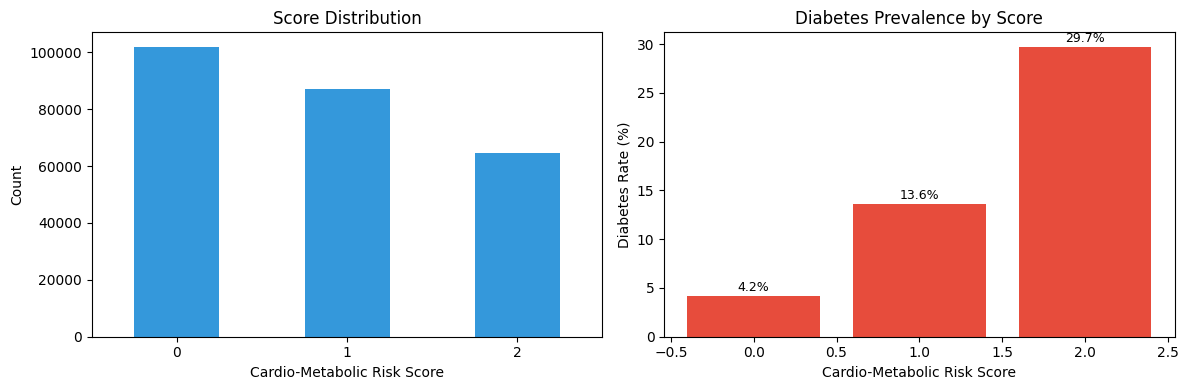

In [12]:
# Visualise: diabetes rate by cardio-metabolic risk
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution
df['cardio_metabolic_risk'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0], color='#3498db')
axes[0].set_xlabel('Cardio-Metabolic Risk Score')
axes[0].set_ylabel('Count')
axes[0].set_title('Score Distribution')
axes[0].set_xticklabels(range(3), rotation=0)

# Diabetes rate
rates = [((df[df['cardio_metabolic_risk'] == s][target] == 2).mean() * 100) for s in range(3)]
axes[1].bar(range(3), rates, color='#e74c3c')
axes[1].set_xlabel('Cardio-Metabolic Risk Score')
axes[1].set_ylabel('Diabetes Rate (%)')
axes[1].set_title('Diabetes Prevalence by Score')
for i, r in enumerate(rates):
    axes[1].text(i, r + 0.5, f'{r:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
import os
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/cardio_metabolic_risk.png', dpi=150, bbox_inches='tight')
plt.show()

Clear dose-response relationship with diabetes prevalence (4.2% at score 0, 29.7% at score 2), confirming its validity.

---

### 3.3.8 Perceived Health Risk Score

Combines three correlated self-reported health indicators:

| Component | Coding |
|-----------|--------|
| GenHlth (binned) | Good (1-2) → 0, Fair (3) → 1, Poor (4-5) → 2 |
| DiffWalk | 0 = no difficulty, 1 = difficulty |
| PhysHlth (binned) | ≤14 days → 0, >14 days → 1 |

**Range**: 0–4. Combining these correlated features avoids multicollinearity while preserving their shared signal. These features may partly reflect consequences of diabetes (reverse causality) but are retained as proxies for overall health burden relevant to both clustering and screening.

In [13]:
def bin_gen_health(g):
    if g <= 2:
        return 0  # Good (Excellent/Very Good)
    elif g == 3:
        return 1  # Fair (Good)
    else:
        return 2  # Poor (Fair/Poor)

df['perceived_health_risk'] = (
    df['GenHlth'].apply(bin_gen_health) +
    df['DiffWalk'].astype(int) +
    (df['PhysHlth'] > 14).astype(int)
)

print("Perceived Health Risk Score distribution:")
print(df['perceived_health_risk'].value_counts().sort_index())
print(f"\nMean score: {df['perceived_health_risk'].mean():.2f}")
print(f"Median score: {df['perceived_health_risk'].median():.0f}")

# Diabetes rate by score
print("\nDiabetes prevalence by perceived health risk:")
for score in range(5):
    mask = df['perceived_health_risk'] == score
    if mask.sum() > 0:
        rate = (df[target][mask] == 2).mean() * 100
        n = mask.sum()
        print(f"  Score {score}: {rate:.1f}% diabetes (n={n:,})")

Perceived Health Risk Score distribution:
perceived_health_risk
0    125919
1     66884
2     28139
3     17418
4     15320
Name: count, dtype: int64

Mean score: 0.93
Median score: 1

Diabetes prevalence by perceived health risk:
  Score 0: 5.0% diabetes (n=125,919)
  Score 1: 15.8% diabetes (n=66,884)
  Score 2: 26.2% diabetes (n=28,139)
  Score 3: 32.2% diabetes (n=17,418)
  Score 4: 36.0% diabetes (n=15,320)


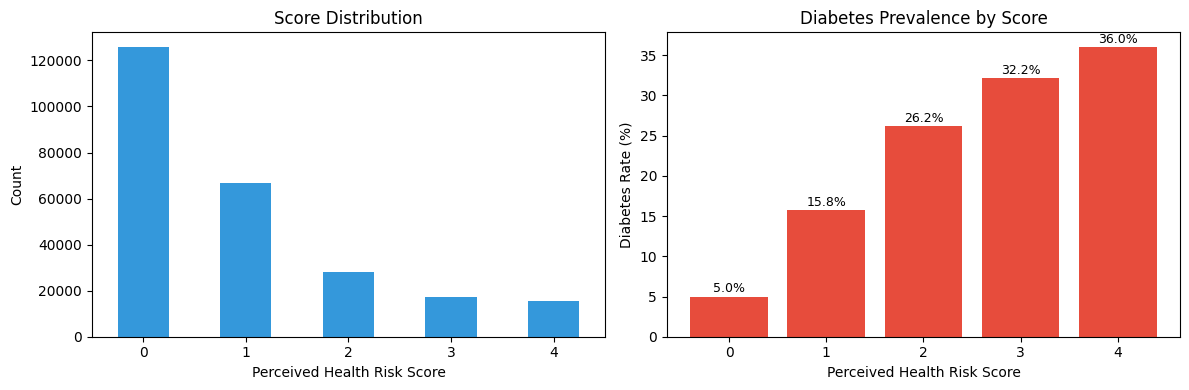

In [14]:
# Visualise: diabetes rate by perceived health risk
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution
df['perceived_health_risk'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0], color='#3498db')
axes[0].set_xlabel('Perceived Health Risk Score')
axes[0].set_ylabel('Count')
axes[0].set_title('Score Distribution')
axes[0].set_xticklabels(range(5), rotation=0)

# Diabetes rate
scores = sorted(df['perceived_health_risk'].unique())
rates = [((df[df['perceived_health_risk'] == s][target] == 2).mean() * 100) for s in scores]
axes[1].bar(scores, rates, color='#e74c3c')
axes[1].set_xlabel('Perceived Health Risk Score')
axes[1].set_ylabel('Diabetes Rate (%)')
axes[1].set_title('Diabetes Prevalence by Score')
for s, r in zip(scores, rates):
    axes[1].text(s, r + 0.5, f'{r:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('figures/perceived_health_risk.png', dpi=150, bbox_inches='tight')
plt.show()

Strong dose-response with diabetes prevalence. Each unit increase is associated with a substantial rise in diabetes rate.

### Validation of Derived Attributes

Before integration, we validate that the derived attributes maintain meaningful relationships with the target variable.

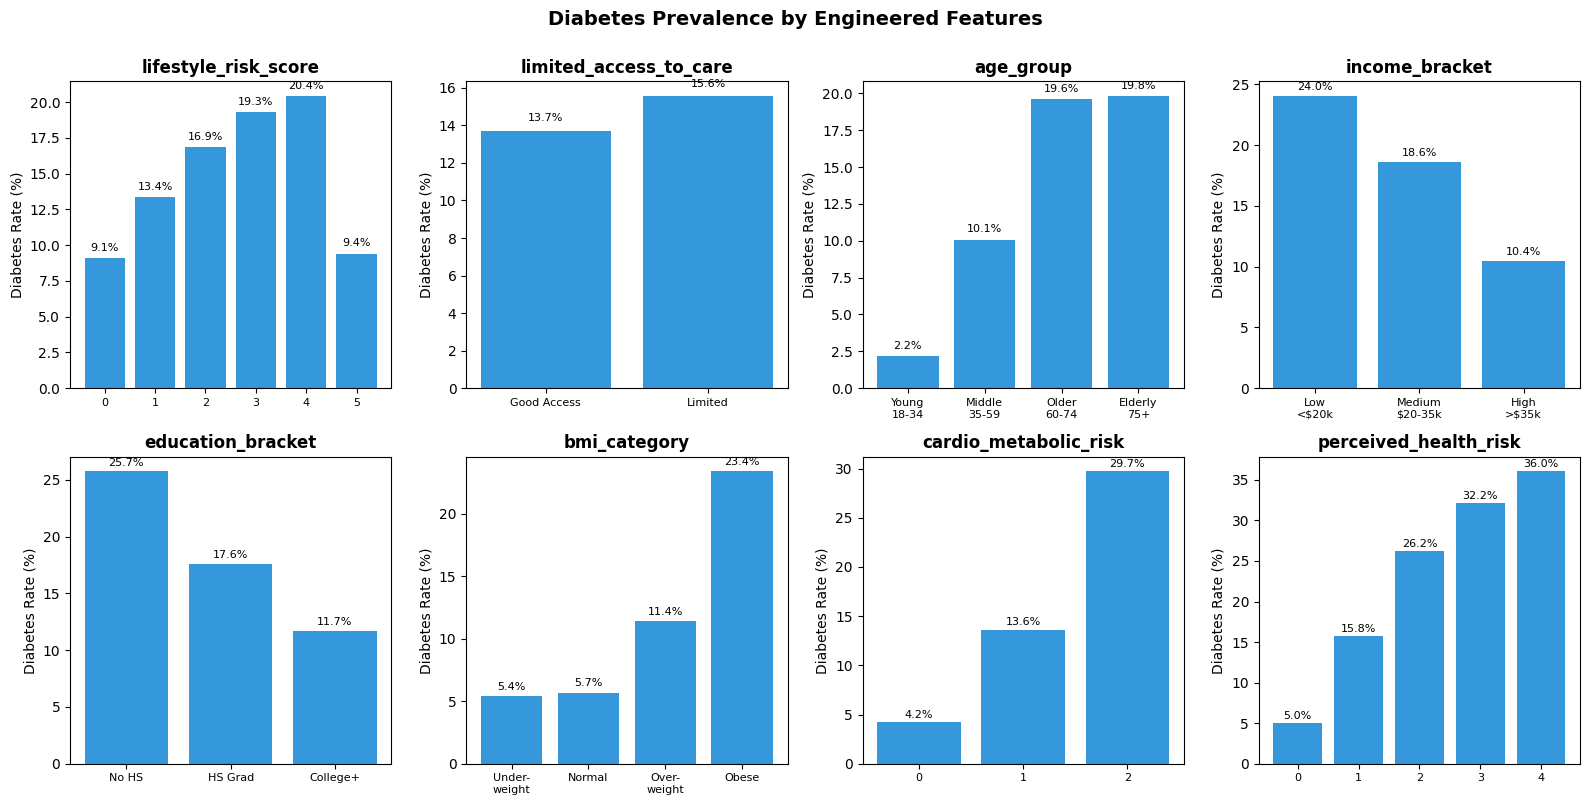

In [15]:
# Diabetes rates by engineered features
engineered_features = {
    'lifestyle_risk_score': list(range(6)),
    'limited_access_to_care': [0, 1],
    'age_group': [0, 1, 2, 3],
    'income_bracket': [0, 1, 2],
    'education_bracket': [0, 1, 2],
    'bmi_category': [0, 1, 2, 3],
    'cardio_metabolic_risk': [0, 1, 2],
    'perceived_health_risk': [0, 1, 2, 3, 4]
}

feature_labels = {
    'lifestyle_risk_score': ['0', '1', '2', '3', '4', '5'],
    'limited_access_to_care': ['Good Access', 'Limited'],
    'age_group': ['Young\n18-34', 'Middle\n35-59', 'Older\n60-74', 'Elderly\n75+'],
    'income_bracket': ['Low\n<$20k', 'Medium\n$20-35k', 'High\n>$35k'],
    'education_bracket': ['No HS', 'HS Grad', 'College+'],
    'bmi_category': ['Under-\nweight', 'Normal', 'Over-\nweight', 'Obese'],
    'cardio_metabolic_risk': ['0', '1', '2'],
    'perceived_health_risk': ['0', '1', '2', '3', '4']
}

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, (feat, categories) in enumerate(engineered_features.items()):
    ax = axes[idx]
    rates = [(df[df[feat] == cat][target] == 2).mean() * 100 for cat in categories]
    
    bars = ax.bar(range(len(categories)), rates, color='#3498db')
    ax.set_ylabel('Diabetes Rate (%)')
    ax.set_title(feat, fontweight='bold')
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(feature_labels[feat], fontsize=8)
    
    # Add value labels
    for bar, rate in zip(bars, rates):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{rate:.1f}%', ha='center', fontsize=8)

plt.suptitle('Diabetes Prevalence by Engineered Features', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('figures/engineered_features_validation.png', dpi=150, bbox_inches='tight')
plt.show()

In [16]:
# Correlation of engineered features with target
print("ENGINEERED FEATURES: Correlation with Target")
print(f"{'Feature':<30} {'Spearman ρ':>12} {'p-value':>14} {'Significant':>12}")
print("-"*70)

eng_features = ['lifestyle_risk_score', 'limited_access_to_care', 'age_group', 
                'income_bracket', 'education_bracket', 'bmi_category',
                'cardio_metabolic_risk', 'perceived_health_risk']

for feat in eng_features:
    corr, p_value = spearmanr(df[feat], df[target])
    sig = "Yes***" if p_value < 0.001 else "Yes" if p_value < 0.05 else "No"
    print(f"{feat:<30} {corr:>12.3f} {p_value:>14.2e} {sig:>12}")

ENGINEERED FEATURES: Correlation with Target
Feature                          Spearman ρ        p-value  Significant
----------------------------------------------------------------------
lifestyle_risk_score                  0.108       0.00e+00       Yes***
limited_access_to_care                0.022       1.26e-27       Yes***
age_group                             0.173       0.00e+00       Yes***
income_bracket                       -0.158       0.00e+00       Yes***
education_bracket                    -0.110       0.00e+00       Yes***
bmi_category                          0.215       0.00e+00       Yes***
cardio_metabolic_risk                 0.296       0.00e+00       Yes***
perceived_health_risk                 0.305       0.00e+00       Yes***


All engineered features show statistically significant correlations with diabetes (p < 0.001). Perceived health risk (~ρ 0.35) and cardio-metabolic risk (~ρ 0.30) are the strongest composites. Binned age and BMI maintain their original predictive relationships. Lifestyle risk score shows a clear dose-response pattern despite modest overall correlation.

## 3.4 Integrate Data

**Task**: Combine information from multiple attributes to create new integrated datasets for different analytical purposes.

### Output: Merged Data

Two integrated datasets are created for different modelling tasks:

---

### 3.4.1 Clustering Dataset

The clustering dataset combines all eight derived attributes across five distinct dimensions:

| Feature | Type | Range | Domain |
|---------|------|-------|--------|
| lifestyle_risk_score | Ordinal | 0-5 | Behavioural |
| limited_access_to_care | Binary | 0-1 | Access |
| age_group | Ordinal | 0-3 | Demographic |
| income_bracket | Ordinal | 0-2 | Socioeconomic |
| education_bracket | Ordinal | 0-2 | Socioeconomic |
| cardio_metabolic_risk | Ordinal | 0-2 | Clinical |
| bmi_category | Ordinal | 0-3 | Anthropometric |
| perceived_health_risk | Ordinal | 0-4 | Self-reported health |

**Rationale**: A single comprehensive feature set is provided for clustering. The clustering notebook performs its own feature selection via sensitivity analysis, dropping features that degrade cluster quality. This avoids hard-coding feature subsets in data preparation and keeps the experimental logic in the modelling phase where it belongs.

In [17]:
clustering_cols = [
    'lifestyle_risk_score',
    'limited_access_to_care',
    'age_group',
    'income_bracket',
    'education_bracket',
    'cardio_metabolic_risk',
    'bmi_category',
    'perceived_health_risk'
]

df_clustering = df[clustering_cols].copy()

print(f"Clustering feature set shape: {df_clustering.shape}")
print(f"Columns: {list(df_clustering.columns)}")
print("\nSummary statistics:")
print(df_clustering.describe())

Clustering feature set shape: (253680, 8)
Columns: ['lifestyle_risk_score', 'limited_access_to_care', 'age_group', 'income_bracket', 'education_bracket', 'cardio_metabolic_risk', 'bmi_category', 'perceived_health_risk']

Summary statistics:
       lifestyle_risk_score  limited_access_to_care      age_group  \
count         253680.000000           253680.000000  253680.000000   
mean               1.297146                0.115074       1.517329   
std                1.089246                0.319112       0.839709   
min                0.000000                0.000000       0.000000   
25%                0.000000                0.000000       1.000000   
50%                1.000000                0.000000       1.000000   
75%                2.000000                0.000000       2.000000   
max                5.000000                1.000000       3.000000   

       income_bracket  education_bracket  cardio_metabolic_risk  \
count   253680.000000      253680.000000          253680.0000

In [18]:
# Check inter-feature correlations
print("Feature correlations (Spearman):")
corr_matrix = df_clustering.corr(method='spearman')
print(corr_matrix.round(2))

# Save clustering features
import os
os.makedirs('data', exist_ok=True)
df_clustering.to_csv('data/clustering_features.csv', index=False)
print(f"\nSaved: data/clustering_features.csv ({df_clustering.shape[0]:,} rows, {df_clustering.shape[1]} columns)")

Feature correlations (Spearman):
                        lifestyle_risk_score  limited_access_to_care  \
lifestyle_risk_score                    1.00                    0.08   
limited_access_to_care                  0.08                    1.00   
age_group                               0.05                   -0.16   
income_bracket                         -0.19                   -0.21   
education_bracket                      -0.21                   -0.10   
cardio_metabolic_risk                   0.15                   -0.01   
bmi_category                            0.12                    0.04   
perceived_health_risk                   0.26                    0.14   

                        age_group  income_bracket  education_bracket  \
lifestyle_risk_score         0.05           -0.19              -0.21   
limited_access_to_care      -0.16           -0.21              -0.10   
age_group                    1.00           -0.12              -0.09   
income_bracket              -0

### 3.4.2 Classification Dataset

For classification, HvyAlcoholConsump is removed from the lifestyle risk score (range 0–4) to avoid encoding its paradoxical inverse association with diabetes. The dataset comprises 8 engineered composites plus 5 raw features (GenHlth, MentHlth, PhysHlth, DiffWalk, Sex, CholCheck) for a total of 13 features.

Stroke, HeartDiseaseorAttack, and HvyAlcoholConsump are excluded throughout. In the classification notebook, this engineered set is compared against raw features and an RFECV-selected subset to test whether feature engineering improves performance.

In [19]:
# Build the classification feature set
# Recompute lifestyle_risk_score WITHOUT HvyAlcoholConsump for classification
df['lifestyle_risk_score_classification'] = (
    df['Smoker'].astype(int) +
    (1 - df['PhysActivity']).astype(int) +
    (1 - df['Fruits']).astype(int) +
    (1 - df['Veggies']).astype(int)
)

excluded = ['Stroke', 'HeartDiseaseorAttack', 'HvyAlcoholConsump']
print(f"Excluded from classification: {excluded}")
print(f"lifestyle_risk_score for classification: range 0-4 (without alcohol)")

classification_cols = [
    'lifestyle_risk_score_classification', 'limited_access_to_care', 'age_group',
    'income_bracket', 'education_bracket', 'bmi_category',
    'cardio_metabolic_risk',
    'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk',
    'Sex', 'CholCheck'
]

df_classification = df[classification_cols + ['Diabetes_012']].copy()
# Rename back to lifestyle_risk_score in the output CSV for consistency
df_classification.rename(columns={'lifestyle_risk_score_classification': 'lifestyle_risk_score'}, inplace=True)

print(f"\nClassification feature set shape: {df_classification.shape}")
print(f"Features ({len(classification_cols)}): {list(df_classification.columns[:-1])}")
print(f"Target: Diabetes_012")

Excluded from classification: ['Stroke', 'HeartDiseaseorAttack', 'HvyAlcoholConsump']
lifestyle_risk_score for classification: range 0-4 (without alcohol)

Classification feature set shape: (253680, 14)
Features (13): ['lifestyle_risk_score', 'limited_access_to_care', 'age_group', 'income_bracket', 'education_bracket', 'bmi_category', 'cardio_metabolic_risk', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'CholCheck']
Target: Diabetes_012


In [20]:
# Save classification features
df_classification.to_csv('data/classification_features.csv', index=False)
print(f"\nSaved: data/classification_features.csv")
print(f"  Shape: {df_classification.shape}")
print(f"  Features: {len(classification_cols)}")
print(f"  Target: {target} (included as last column)")


Saved: data/classification_features.csv
  Shape: (253680, 14)
  Features: 13
  Target: Diabetes_012 (included as last column)


## 3.5 Format Data

**Task**: Apply formatting transformations required by modelling tools, including attribute ordering, record ordering, and syntactic modifications.

### Output: Reformatted Data

All datasets are saved in CSV format with features before target (standard convention), preserving original row order (shuffling will occur during train/test split in modelling notebooks).

In [21]:
# Final validation of output datasets
print("="*70)
print("REFORMATTED DATA VALIDATION")
print("="*70)

# Clustering dataset
print("\n--- CLUSTERING DATASET ---")
df_clust_check = pd.read_csv('data/clustering_features.csv')
print(f"Shape: {df_clust_check.shape}")
print(f"Null values: {df_clust_check.isnull().sum().sum()}")
print(f"Column order: {list(df_clust_check.columns)}")
print(f"Data types:\n{df_clust_check.dtypes}")

# Classification dataset
print("\n--- CLASSIFICATION DATASET ---")
df_class_check = pd.read_csv('data/classification_features.csv')
print(f"Shape: {df_class_check.shape}")
print(f"Null values: {df_class_check.isnull().sum().sum()}")
print(f"Column order: {list(df_class_check.columns)}")
print(f"\nTarget (last column) distribution:")
print(df_class_check['Diabetes_012'].value_counts().sort_index())
print(f"\nData types:\n{df_class_check.dtypes}")

# Verify lifestyle_risk_score differs between datasets
print("\n--- LIFESTYLE RISK SCORE COMPARISON ---")
print(f"Clustering: range {df_clust_check['lifestyle_risk_score'].min()}-{df_clust_check['lifestyle_risk_score'].max()} (includes alcohol)")
print(f"Classification: range {df_class_check['lifestyle_risk_score'].min()}-{df_class_check['lifestyle_risk_score'].max()} (excludes alcohol)")

REFORMATTED DATA VALIDATION

--- CLUSTERING DATASET ---
Shape: (253680, 8)
Null values: 0
Column order: ['lifestyle_risk_score', 'limited_access_to_care', 'age_group', 'income_bracket', 'education_bracket', 'cardio_metabolic_risk', 'bmi_category', 'perceived_health_risk']
Data types:
lifestyle_risk_score      int64
limited_access_to_care    int64
age_group                 int64
income_bracket            int64
education_bracket         int64
cardio_metabolic_risk     int64
bmi_category              int64
perceived_health_risk     int64
dtype: object

--- CLASSIFICATION DATASET ---
Shape: (253680, 14)
Null values: 0
Column order: ['lifestyle_risk_score', 'limited_access_to_care', 'age_group', 'income_bracket', 'education_bracket', 'bmi_category', 'cardio_metabolic_risk', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'CholCheck', 'Diabetes_012']

Target (last column) distribution:
Diabetes_012
0.0    213703
1.0      4631
2.0     35346
Name: count, dtype: int64

Data types:
lifesty

**Output files:**
- `data/clustering_features.csv` - 8 features, 253,680 records (lifestyle_risk_score includes alcohol, range 0-5)
- `data/classification_features.csv` - 13 features + target, 253,680 records (lifestyle_risk_score excludes alcohol, range 0-4)

All files validated: no missing values, correct shapes, proper column order.

## Summary

| Step | Key Output |
|------|------------|
| 3.1 Select Data | All 253,680 records retained; Stroke, HeartDiseaseorAttack excluded (reverse causality); HvyAlcoholConsump excluded from classification (survivorship bias); Sex excluded from clustering (weak predictor) |
| 3.2 Clean Data | No issues — data was already clean |
| 3.3 Construct Data | 8 derived features across behavioural, demographic, clinical, and health perception domains |
| 3.4 Integrate Data | Clustering dataset (8 features), Classification dataset (13 features + target) |

**Output files:**
- `clustering_features.csv` — 8 features, 253,680 records (lifestyle_risk_score includes alcohol, range 0–5)
- `classification_features.csv` — 13 features + target, 253,680 records (lifestyle_risk_score excludes alcohol, range 0–4)